## Assignment
## A1 - Predicting Car Prices
Name: Alston Alvares            Student ID: st126488

Output and Report at the end of this file

In [49]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# load the dataset
data = pd.read_csv('Cars.csv')

In [51]:
# perform EDA
print(data.head())
print(data.info())
print(data.isnull().sum())
print(data.columns)

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250N

In [52]:
# For the feature owner, mapped the First owner to 1, ..., and so on, Test Drive Car to 5
data.columns = data.columns.str.lower()
owner_map = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
data['owner'] = data['owner'].astype(str).str.strip().replace(owner_map)

C:\Users\alsto\AppData\Local\Temp\ipykernel_33684\4152730367.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['owner'] = data['owner'].astype(str).str.strip().replace(owner_map)


In [53]:
# Removed rows where fuel type is CNG or LPG
data = data[~data['fuel'].isin(['CNG', 'LPG'])]


In [54]:
# Process the 'mileage' feature by removing ' kmpl' and ' km/kg', then converting to numeric
data['mileage'] = pd.to_numeric(
    data['mileage'].astype(str).str.extract(r'([\d\.]+)')[0],
    errors='coerce'
)


In [55]:
# Processed the 'engine' feature
data['engine'] = pd.to_numeric(
	data['engine'].astype(str).str.replace(' CC', '', regex=False),
	errors='coerce'
)

# Processed the 'max power' feature
data['max_power'] = pd.to_numeric(
	data['max_power'].astype(str).str.replace(' bhp', '', regex=False),
	errors='coerce'
)

# Modified 'brand' feature to retain only the first word.
if 'brand' not in data.columns:
	data['brand'] = data['name'].astype(str).str.split().str[0]
else:
	data['brand'] = data['brand'].astype(str).str.split().str[0]

In [56]:
#Droped the feature torque
data = data.drop(columns=['torque'])


In [57]:
# Deleted Test Drive Cars
data = data[data['owner'] != 5]



In [58]:
# Trasnsformed selling price label using log transform
y = np.log(data['selling_price'])



In [59]:
# split the data
from sklearn.model_selection import train_test_split
y = np.log(data['selling_price'])                # target from current data
X = data.drop(columns=['selling_price', 'name'], errors='ignore')  # drop non-features

# dropped rows with missing values in either X or y and align indices
df_model = pd.concat([X, y], axis=1).dropna()
X = df_model.drop(columns=['selling_price']).reset_index(drop=True)
y = df_model['selling_price'].reset_index(drop=True)



In [ ]:
# confirmed the rows in X and y are the same
print('X rows:', len(X), 'y rows:', len(y))
# split the data into training and testing sets 80% train, 20% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X rows: 7814 y rows: 7814


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# identified the numerical and categorical columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# performed preprocessing by creating a ColumnTransformer because we have both numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='drop')

# created pipeline with preprocessing and model
model = Pipeline([
    ('preproc', preprocessor),
    ('reg', LinearRegression())
])

# fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 0.0596
R^2 Score: 0.9113


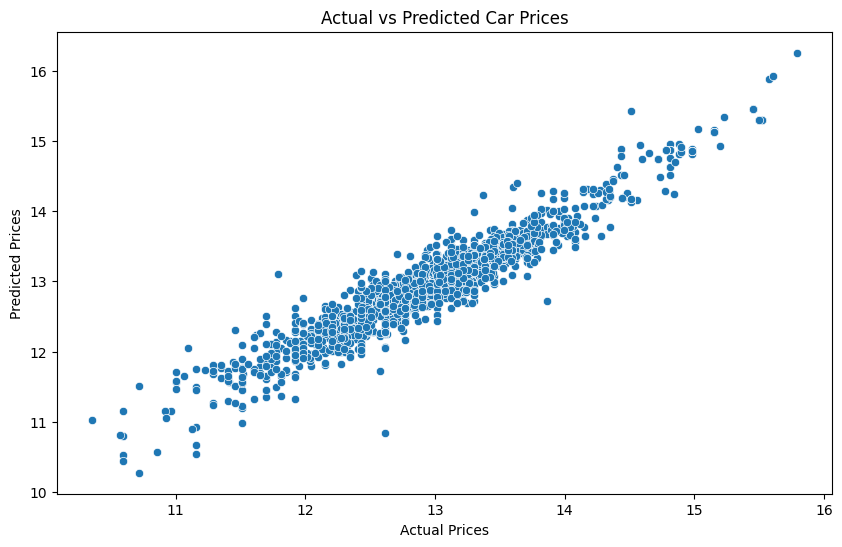

In [62]:
# visualized the results
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Car Prices')
plt.show()

In [ ]:
import os, json, joblib

os.makedirs("deploy_assets", exist_ok=True)

# Saved the assets
assets = {
    "features": ["year","km_driven","fuel","seller_type","transmission","owner","mileage","engine","max_power","seats","brand"],
    "num_cols": ["year","km_driven","owner","mileage","engine","max_power","seats"],
    "cat_cols": ["fuel","seller_type","transmission","brand"]
}

# Saved assets to JSON file
with open("deploy_assets/assets.json", "w", encoding="utf-8") as f:
    json.dump(assets, f, indent=2)

# Saved the pipeline
try:
    joblib.dump(model, "deploy_assets/pipeline.joblib")
    print("Saved pipeline.joblib and assets.json to deploy_assets/")
except Exception as e:
    print("Warning: failed to save pipeline.joblib:", e)

Saved pipeline.joblib and assets.json to deploy_assets/


In [ ]:


# 1. Load model 
model_path = "deploy_assets/pipeline.joblib"
model = None

# Attempt to load the model from file
if os.path.exists(model_path):
    try:
        model = joblib.load(model_path)
    except Exception as e:
        print(f"Warning: Failed to load model from {model_path}: {e}")

# If file not found and no globals, raise error
if model is None:
    if 'model' in globals():
        model = globals()['model']
    else:
        raise FileNotFoundError(
            f"Model file not found at {model_path} and no in-memory 'model' available."
        )

# 2. Load metadata (features, column types)
assets_path = "deploy_assets/assets.json"
features = None
num_cols = None
cat_cols = None

if os.path.exists(assets_path):
    try:
        # Load and parse the JSON file
        with open(assets_path, "r", encoding="utf-8") as fh:
            assets = json.load(fh)
        features = assets.get("features") if isinstance(assets, dict) else None
        num_cols = assets.get("num_cols") if isinstance(assets, dict) else None
        cat_cols = assets.get("cat_cols") if isinstance(assets, dict) else None
    except Exception as e:
        # log the error 
        print(f"Warning: Failed to load or parse assets file {assets_path}: {e}")

if features is None or num_cols is None or cat_cols is None:
    if (
        # Check if 'num_cols' and 'cat_cols' exist in globals and are not None
        'num_cols' in globals()
        and 'cat_cols' in globals()
        and globals().get('num_cols') is not None
        and globals().get('cat_cols') is not None
    ):
        num_cols = globals()['num_cols']
        cat_cols = globals()['cat_cols']
        
        # Ensuring they are lists before concatenation
        num_cols = list(num_cols)
        cat_cols = list(cat_cols)
        features = num_cols + cat_cols
    elif 'X' in globals():
        # Deriving metadata from the dataframe X 
        X_local = globals()['X']
        features = X_local.columns.tolist()
        num_cols = X_local.select_dtypes(include=['number']).columns.tolist()
        cat_cols = X_local.select_dtypes(exclude=['number']).columns.tolist()
    else:
        # If file not found and no globals, raise error
        raise FileNotFoundError(
            f"Assets file not found or invalid at {assets_path} and required variables are not available in the notebook environment."
        )

# convert to lists if not already
features = list(features) if features is not None else []
num_cols = list(num_cols) if num_cols is not None else []
cat_cols = list(cat_cols) if cat_cols is not None else []

print("Features:", features)
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Features: ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats', 'brand']
Numerical columns: ['year', 'km_driven', 'owner', 'mileage', 'engine', 'max_power', 'seats']
Categorical columns: ['fuel', 'seller_type', 'transmission', 'brand']


## Output:

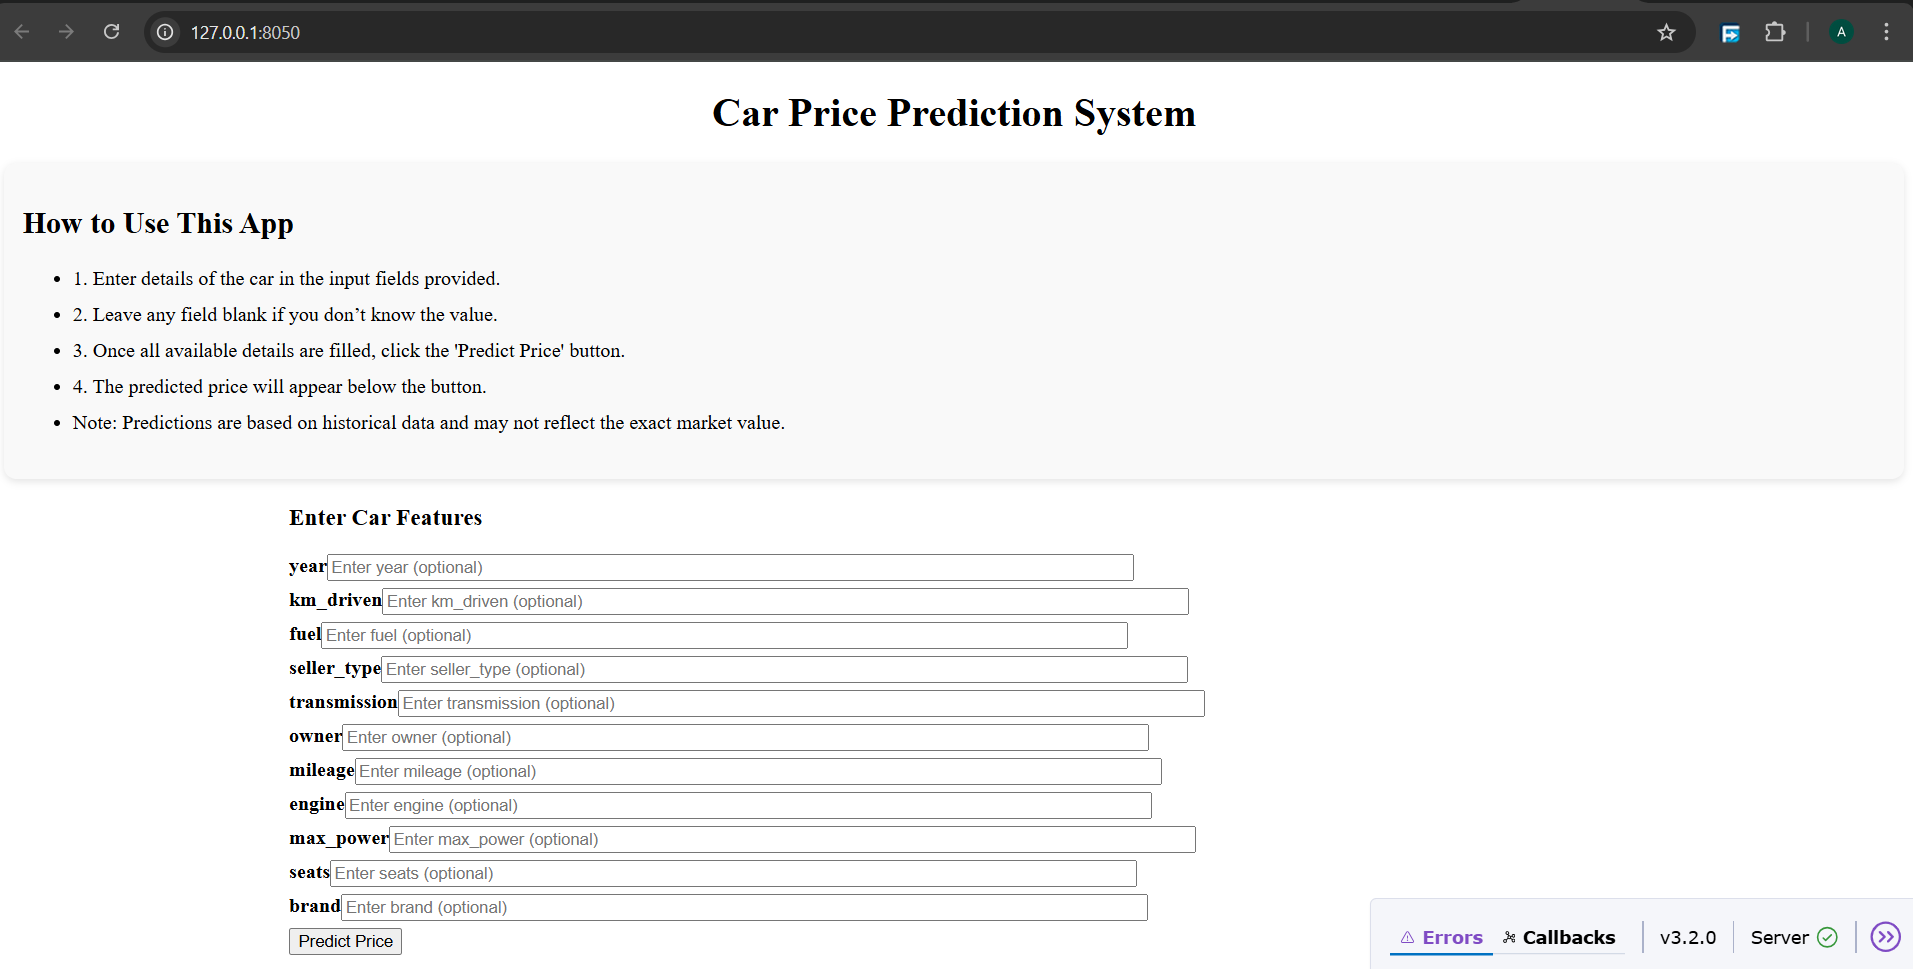

Added Brand Name to get a price

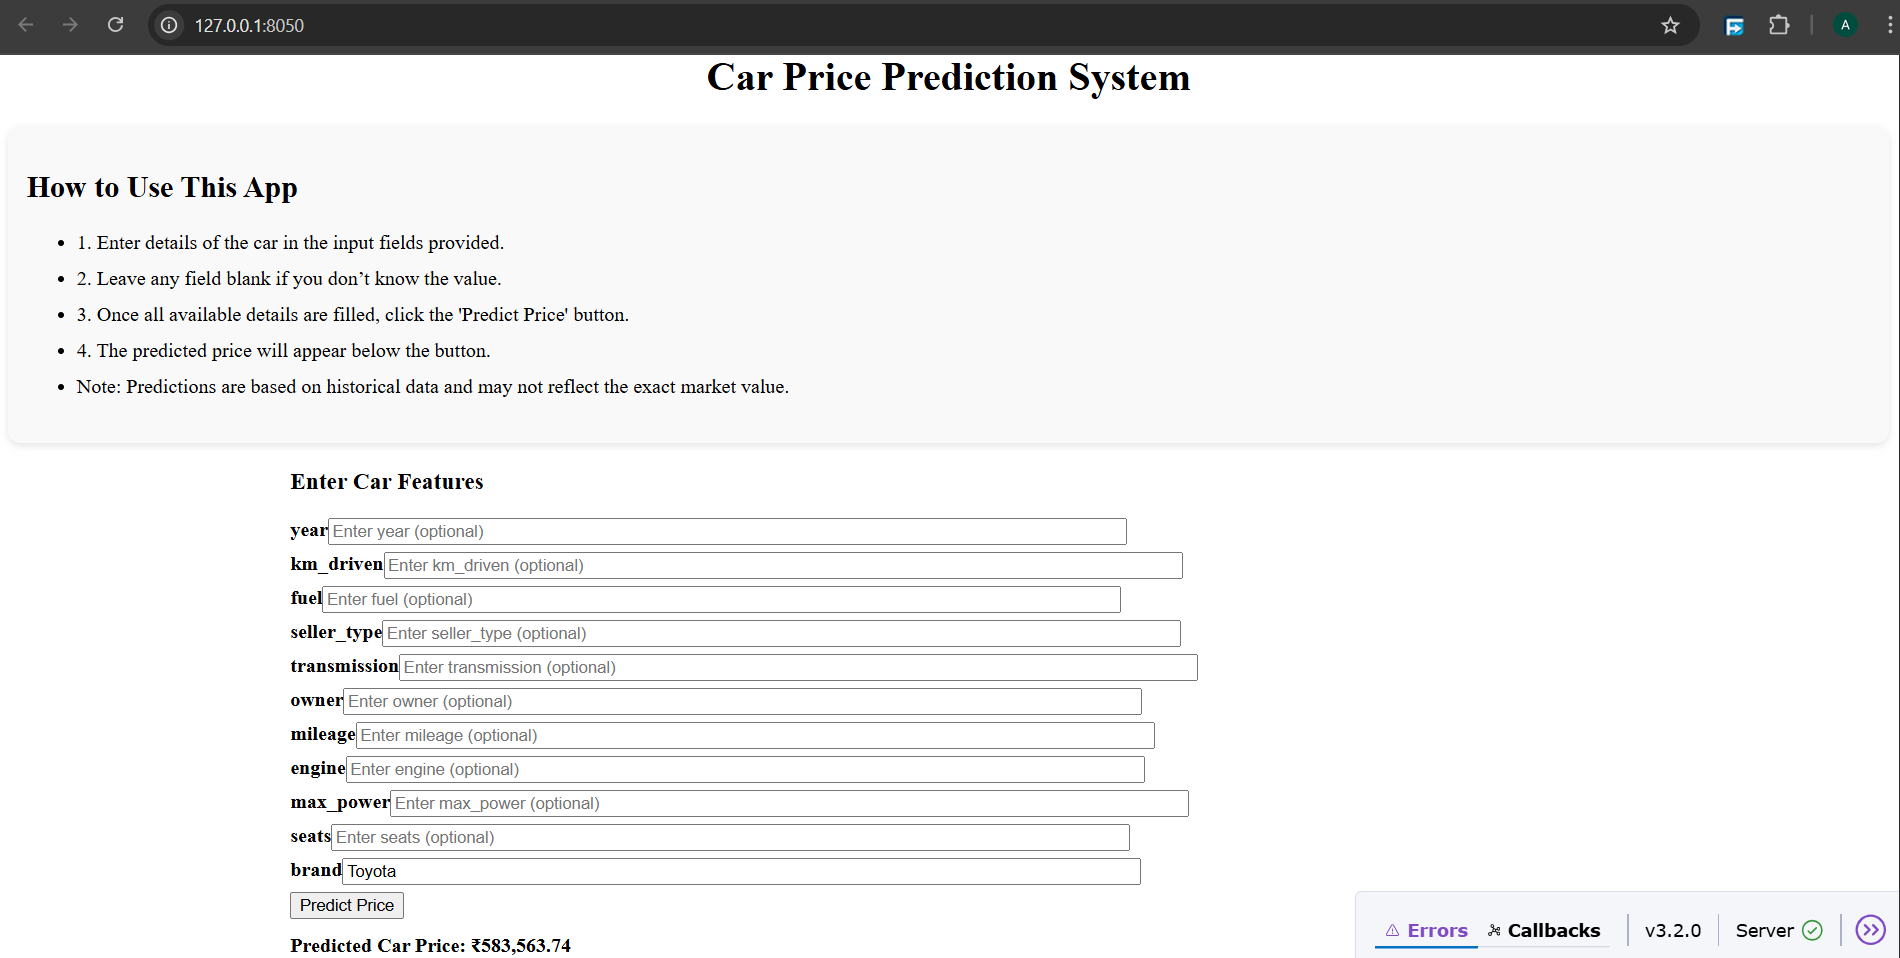

Changet the owner and saw the change in price clearly displayed

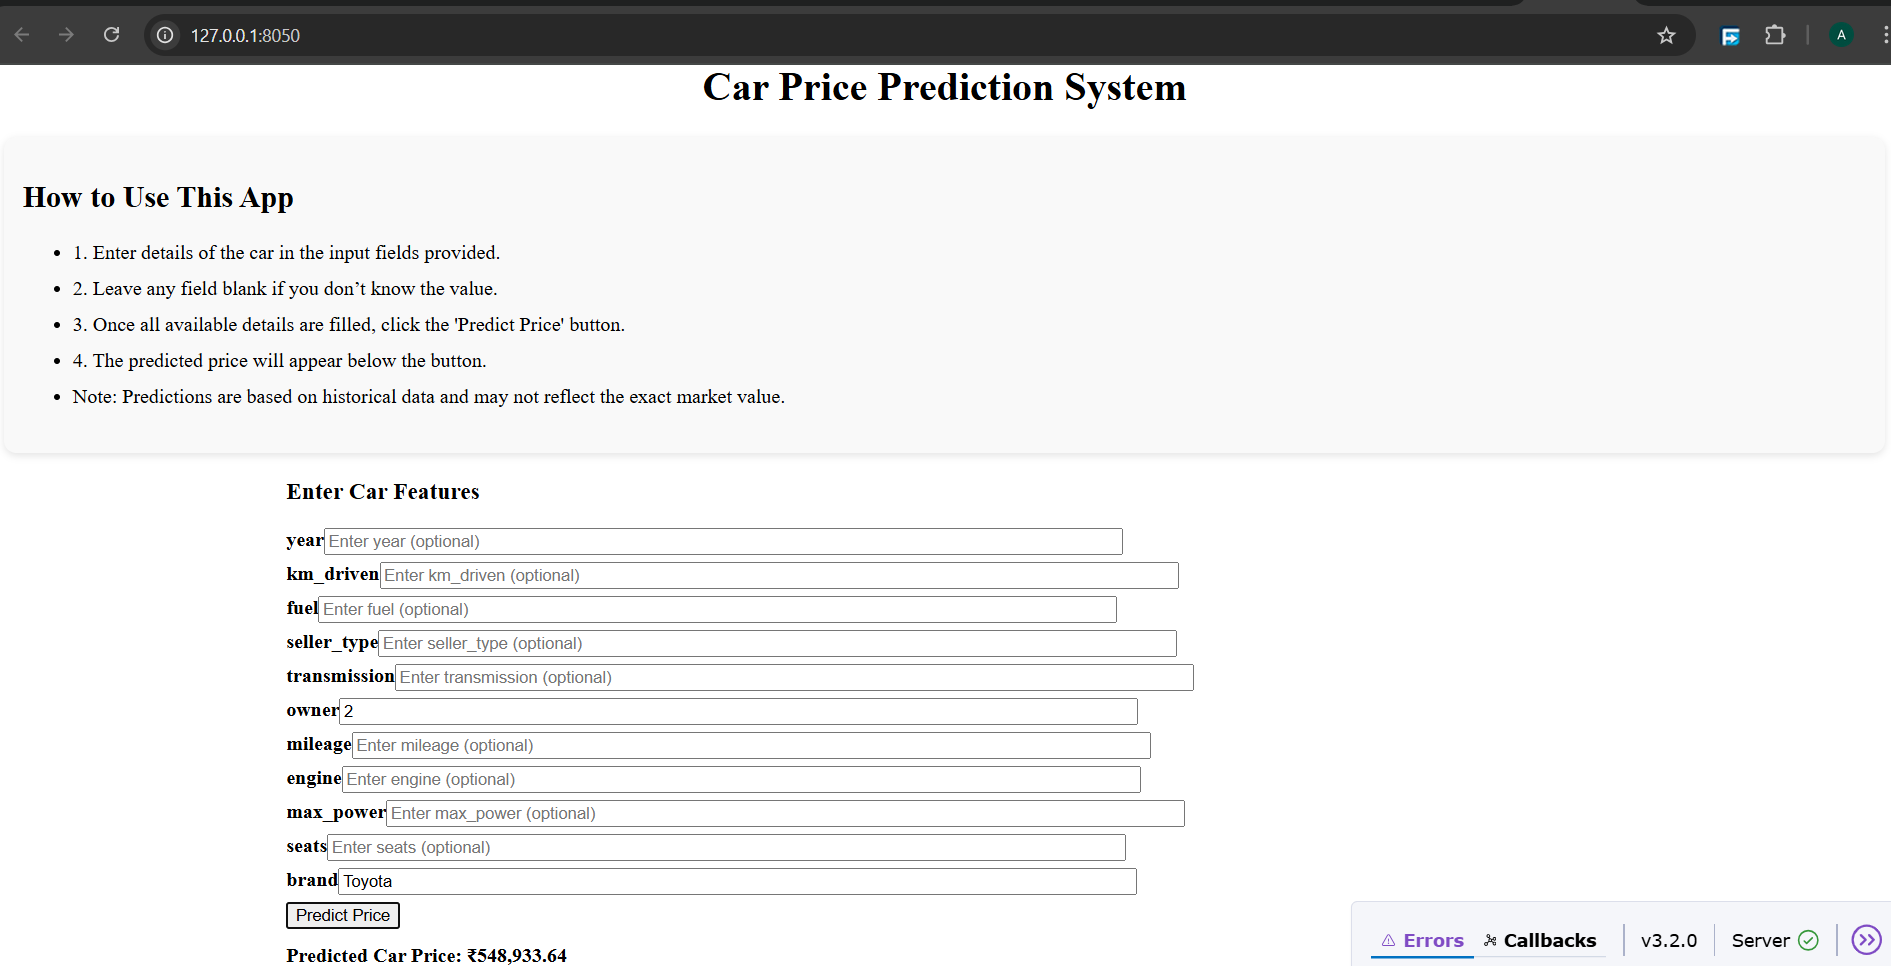

Added km driven to see if price changes and it did successfully
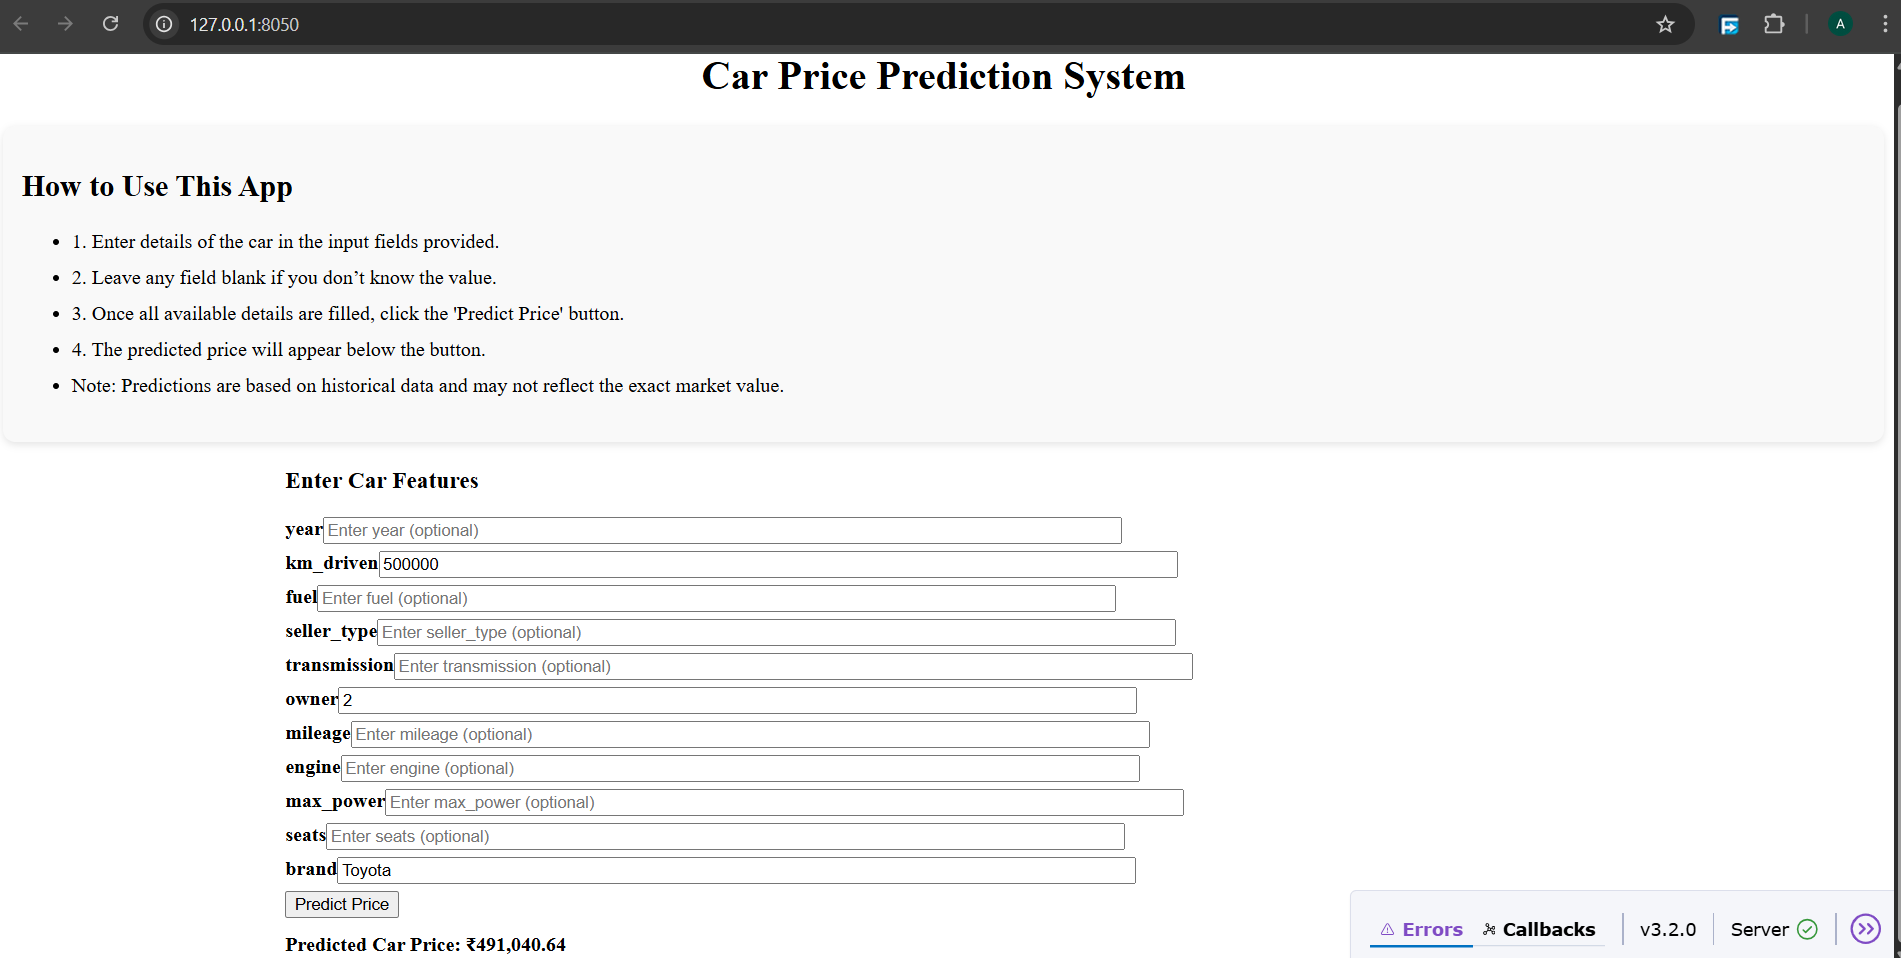

## Report:

In this assignment, car prediction model was created with features like brands, owner, etc. It was understood that features influenced the price. The features that mainly influenced the price were no of owners, brand, milage, year and km driven. Preprocessing was a little tricky as it had to be done carefully. For preprcessing the things done were text features converted to numeric, extracted the brands and applied log transformation.


Linear regression algorithm was used for this assignment. Researched about few algorithms like Random Forest and gradient boosting, they were better for non linear interaction between the features, while linear regression offered a very good base and was a little tricky. I also researched about a classification algorithm k-nearest neighbors it was less suitable for regression.For the features i didnt select were seler type and transmission as these didnt have much impact to the price compared to the features mentioned above.

Understanding which features are most strongly influencing car price not only improves the models performance but also gives us insights for car buyers and sellers and also chaky company.